In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns
import random

from os import listdir
from os.path import isfile, join

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import csv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [10]:
df_work = pd.read_csv('labels_and_features_20.csv')
df_work.head()

,name,q_Imax,Imax_over_Imean,Imax_over_Imean_local,fluctuation_strength,low_q_ratio,high_q_ratio,Imax_over_Ilowq,Imax_over_Ihighq,Ilowq_over_Ihighq,...,b_s_16,b_s_17,b_s_18,b_s_19,b_s_20,bad_data,form,precursor,structure,str_label
0,R1_1stcool_0001_dz_bgsub,0.04,18.752705,1.039870,0.811895,0.997521,0.002479,2.115803,2701.707990,1276.918254,...,0.0,0.0,0.0,0.0,0.0,False,True,False,False,form_
1,R1_1stcool_0002_dz_bgsub,0.04,18.734222,1.038783,0.783708,0.997605,0.002395,2.113128,2794.106192,1322.260858,...,0.0,0.0,0.0,0.0,0.0,False,True,False,False,form_
2,R1_1stcool_0003_dz_bgsub,0.04,18.700700,1.038475,0.776179,0.997004,0.002996,2.113709,2229.346670,1054.708362,...,0.0,0.0,0.0,0.0,0.0,False,True,False,False,form_
3,R1_1stcool_0004_dz_bgsub,0.04,18.811386,1.041716,0.706750,0.998057,0.001943,2.120315,3457.665126,1630.731639,...,0.0,0.0,0.0,0.0,0.0,False,True,False,False,form_
4,R1_1stcool_0005_dz_bgsub,0.04,18.695330,1.038356,0.757558,0.998090,0.001910,2.108819,3494.979851,1657.316125,...,0.0,0.0,0.0,0.0,0.0,False,True,False,False,form_


In [11]:
df_work.shape

(1946, 35)

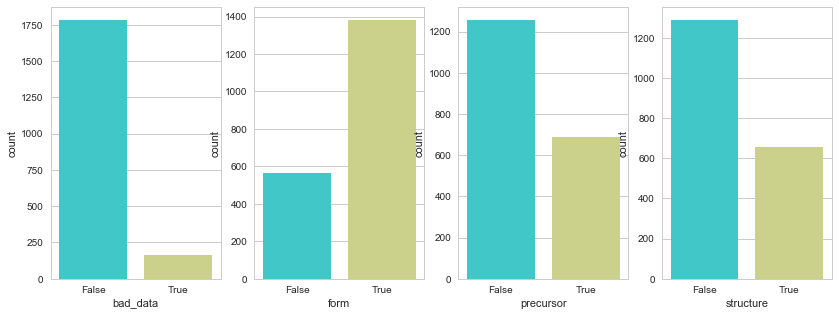

In [12]:
branches = ['bad_data', 'form', 'precursor', 'structure']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14,5))

for n in range(4): # max number of classes is 9, but we have only 6 now
    br = branches[n]
    sns.countplot(x=br, data=df_work, palette='rainbow', ax=axes[n])

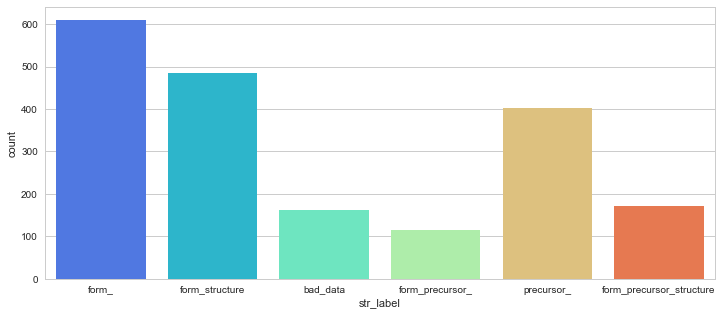

In [13]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(12,5))
sns.countplot(data=df_work, x='str_label',palette='rainbow')

## Splitting Data into training and validataion sets

We have only 1946 samples, thus, I am going to use cross validation.

In [15]:
shuffled_rows = np.random.permutation(df_work.index)
df_work = df_work.loc[shuffled_rows]

train = df_work.iloc[ : 1746]
val = df_work.iloc[1746: ]

Our goal is to predict four labels "bad_data," "form," "precursor," and "structure."

When a sample have "bad_data" : True, it must have "False" for other three labels. 

When a sample have "bad_data" : False, it can have any combinations of other labels.

Thus, I am going to create a binary classificaton for every type of labels. The "form," "precursor," and "structure" classification will be used only for data with "bad_data" : False label.

In [55]:
train.shape

(1746, 35)

In [56]:
val.shape

(200, 35)

## Bad Data

In [17]:
features = ['b_s_1',
       'b_s_2', 'b_s_3', 'b_s_4', 'b_s_5', 'b_s_6', 'b_s_7', 'b_s_8', 'b_s_9',
       'b_s_10', 'b_s_11', 'b_s_12'] # since q usially is in range 0 - 0.6, we have only zeros in "b_s_13" - "b_s_20"

features2 = ['q_Imax', 'Imax_over_Imean_local', 'fluctuation_strength',
       'low_q_ratio', 'high_q_ratio', 'Imax_over_Ilowq', 'Ilowq_over_Ihighq']

### Logistic Regression

In [44]:
scaler = preprocessing.StandardScaler()
scaler.fit(train[features2])

StandardScaler(copy=True, with_mean=True, with_std=True)

"Standardize features by removing the mean and scaling to unit variance
Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using the transform method.
Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).
For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected."
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [45]:
# Scaler demo
scaler_demo = preprocessing.StandardScaler()
data = [[0, 0], [0, 0], [1, 1], [1, 1]]
scaler_demo.fit(data)
print("mean: ", scaler_demo.mean_)
print("transformed data: ", scaler_demo.transform(data))
print('transformed [2,2]: ', scaler_demo.transform([[2, 2]]))

mean:  [ 0.5  0.5]
transformed data:  [[-1. -1.]
 [-1. -1.]
 [ 1.  1.]
 [ 1.  1.]]
transformed [2,2]:  [[ 3.  3.]]


### Logistic Regression with analytical features

In [46]:
clf = linear_model.SGDClassifier()
scores = cross_val_score(clf, scaler.transform(train[features2]), train['bad_data'], cv=5)
scores.mean()

0.98911338518215308

In [47]:
clf.fit(scaler.transform(train[features2]), train['bad_data'])
clf.score(scaler.transform(val[features2]), val['bad_data'])

0.98499999999999999

We got accuracy 98.9% on training set using 5-folders cross validation and 
98.5% on validation set. 

### Logistic Regression using bin strengh as features

In [51]:
scaler = preprocessing.StandardScaler()
scaler.fit(train[features])
clf = linear_model.SGDClassifier()
scores = cross_val_score(clf, scaler.transform(train[features]), train['bad_data'], cv=5)
scores.mean()

0.96562423250102347

In [52]:
clf.fit(scaler.transform(train[features]), train['bad_data'])
clf.score(scaler.transform(val[features]), val['bad_data'])

0.97499999999999998

We got accuracy 96.6% on training set using 5-folders cross validation and 
97.5% on validation set. Analytical features work slightly better than bin strengh. 

### Now we will use only samples that have label "bad_data" : False

In [57]:
#now we need only "good" data
train_good = train[train['bad_data']==False]
train_good.shape

(1605, 35)

In [58]:
val_good = val[val['bad_data']==False]
val_good.shape

(179, 35)

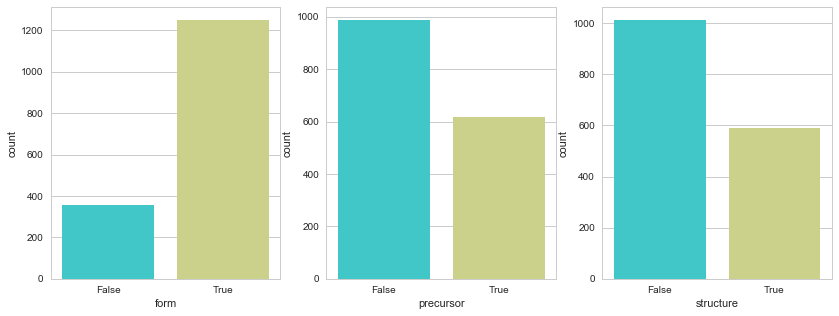

In [59]:
branches = ['form', 'precursor', 'structure']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5))

for n in range(3):
    br = branches[n]
    sns.countplot(x=br, data=train_good, palette='rainbow', ax=axes[n])

## Form Label
### Logistic Regression with analytical features

In [69]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features2])
clf = linear_model.SGDClassifier()
scores = cross_val_score(clf, scaler.transform(train_good[features2]), train_good['form'], cv=5)
scores.mean()

0.98940809968847354

In [70]:
clf.fit(scaler.transform(train_good[features2]), train_good['form'])
clf.score(scaler.transform(val_good[features2]), val_good['form'])

0.97765363128491622

### Logistic Regression using bin strengh as features

In [72]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
clf = linear_model.SGDClassifier()
scores = cross_val_score(clf, scaler.transform(train_good[features]), train_good['form'], cv=5)
scores.mean()

0.99688473520249232

In [73]:
clf.fit(scaler.transform(train_good[features]), train_good['form'])
clf.score(scaler.transform(val_good[features]), val_good['form'])

0.98324022346368711

For "Form" labels, bin strengh works slightly better than analytical features. 

## Precursor Label
### Logistic Regression with analytical features

In [74]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features2])
clf = linear_model.SGDClassifier()
scores = cross_val_score(clf, scaler.transform(train_good[features2]), train_good['precursor'], cv=5)
scores.mean()

0.81481591397225284

In [75]:
clf.fit(scaler.transform(train_good[features2]), train_good['precursor'])
clf.score(scaler.transform(val_good[features2]), val_good['precursor'])

0.83240223463687146

### Logistic Regression using bin strengh as features

In [76]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
clf = linear_model.SGDClassifier()
scores = cross_val_score(clf, scaler.transform(train_good[features]), train_good['precursor'], cv=5)
scores.mean()

0.92895974826338501

In [77]:
clf.fit(scaler.transform(train_good[features]), train_good['precursor'])
clf.score(scaler.transform(val_good[features]), val_good['precursor'])

0.8938547486033519

For "Precursor" labels, bin strengh works also better than analytical features.

## Structure Label
### Logistic Regression with analytical features

In [78]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features2])
clf = linear_model.SGDClassifier()
scores = cross_val_score(clf, scaler.transform(train_good[features2]), train_good['structure'], cv=5)
scores.mean()

0.97569491205665515

In [79]:
clf.fit(scaler.transform(train_good[features2]), train_good['structure'])
clf.score(scaler.transform(val_good[features2]), val_good['structure'])

0.96089385474860334

### Logistic Regression using bin strengh as features

In [82]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
clf = linear_model.SGDClassifier()
scores = cross_val_score(clf, scaler.transform(train_good[features]), train_good['structure'], cv=5)
scores.mean()

0.91965099601400913

In [83]:
clf.fit(scaler.transform(train_good[features]), train_good['structure'])
clf.score(scaler.transform(val_good[features]), val_good['structure'])

0.95530726256983245

Analytical features work better for "Structure" label.

## Results

### Accuracy of Logistic Regression classifiers vs the best result from unsupervised clussifiers

|            | using analytical features (training / validation) | using bin strengt  (training / validation) |  the best unsupervised clussifier (vlidatation set)
| ------------- | ------------- |----------------
| bad_data  | **0.989 / 0.985**  | 0.966 / 0.975 | 0.942
| form  | 0.989 / 0.978  | **0.997 / 0.983** | 0.859
| precursor | 0.815 / 0.832 | **0.929 / 0.894** | 0.816
| structure | **0.976 / 0.961** | 0.920 / 0.955 | 0.918

The result that we got using supervised learning is significant better than we got using unsupervised learning. 